#  Практика 5: Атака с ограниченной памятью (PGD
Projected Gradient Descent)
Цель задания:
 Изучить одну из наиболее мощных атак на модели ИИ — атаку Projected Gradient Descent (PGD).
 Научиться использовать PGD для создания противоречивых примеров и оценить её влияние на
 обученные модели.
 Задачи:
 1. Загрузить ранее обученную модель на датасете MNIST.
 2. Изучить теоретические основы атаки PGD.
 3. Реализовать атаку PGD с помощью фреймворка Foolbox.
 4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
 данных.

 Выполнил студент ББМО-02-23 Евдокимов А.М.


## Шаги выполнения:

### Шаг 1: Загрузка обученной модели и данных MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9731 - loss: 0.0858
Test accuracy on clean images: 0.9772999882698059


###  Шаг 2: Реализация атаки PGD с использованием Foolbox

In [ ]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.6 MB/s eta 0:00:00


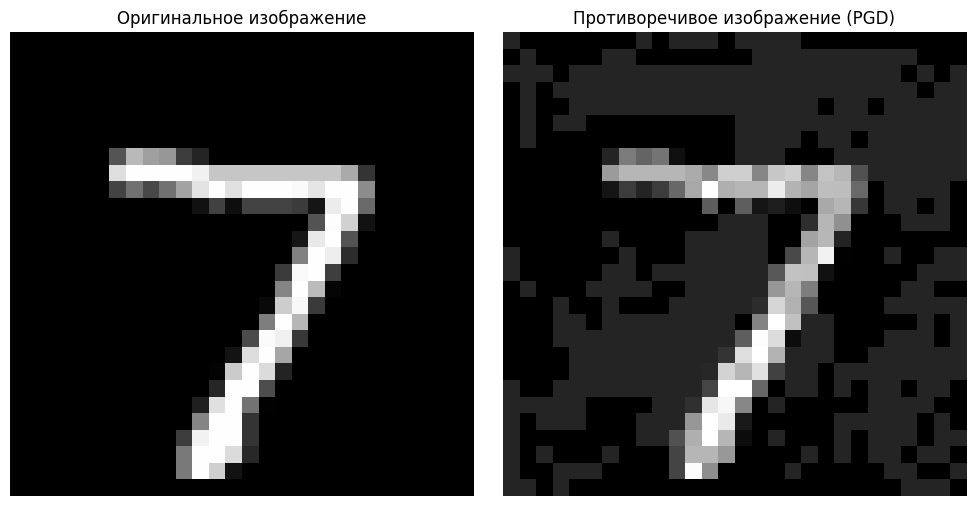

In [ ]:
import foolbox as fb
import tensorflow as tf
import numpy as np

image = tf.convert_to_tensor(test_images[0].reshape(1, 28, 28, 1), dtype=tf.float32)
label = np.argmax(test_labels[0])

# Инициализация Foolbox модели
fmodel = fb.models.TensorFlowModel(model, bounds=(0, 1))

# Создание PGD-атаки
attack = fb.attacks.LinfPGD()

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, np.array([label]), epsilons=0.00000001)

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(tf.squeeze(image).numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(tf.squeeze(adversarial_image).numpy(), cmap="gray")
plt.axis('off')

plt.tight_layout()
plt.show()

### Шаг 3: Оценка модели на противоречивых примерах

In [ ]:
adversarial_images = []

# Обработка всех изображений
for i in range(len(test_images)):
    # Преобразование изображения и метки
    image = tf.convert_to_tensor(test_images[i].reshape(1, 28, 28, 1), dtype=tf.float32)
    label = np.argmax(test_labels[i])  # Преобразование в индекс класса (одномерный)

    # Выполнение атаки
    adversarial_image, _, success = attack(fmodel, image, np.array([label]), epsilons=0.00000001)

    # Добавление атакованного изображения в список
    adversarial_images.append(adversarial_image)

# Преобразование списка атакованных изображений в массив NumPy
adversarial_images = np.array(adversarial_images).reshape(len(test_images), 28, 28, 1)

# Оценка точности модели на атакованных изображениях
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD attack): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0912 - loss: 2.4363
Accuracy on adversarial examples (PGD attack): 0.08919999748468399


## Вывод

Результаты показывают, что модель демонстрирует высокую точность на чистых изображениях, составляющую 97.73%, что указывает на хорошую обобщающую способность и правильную работу модели на тестовом наборе. Однако после применения атаки PGD точность модели значительно снижается до 8.92%, что является ярким примером того, как атакующие примеры могут ослабить работу модели. Также наблюдается значительное увеличение потерь (loss) до 2.4363, что подтверждает, что модель делает гораздо больше ошибок при классификации атакованных примеров.


#### PS. Чуть чуть самодеятельности


Предсказание оригинальное изображение : 9, Accuracy: 99.97%
Предсказание противоречивое изображение: 4, Accuracy: 0.30%


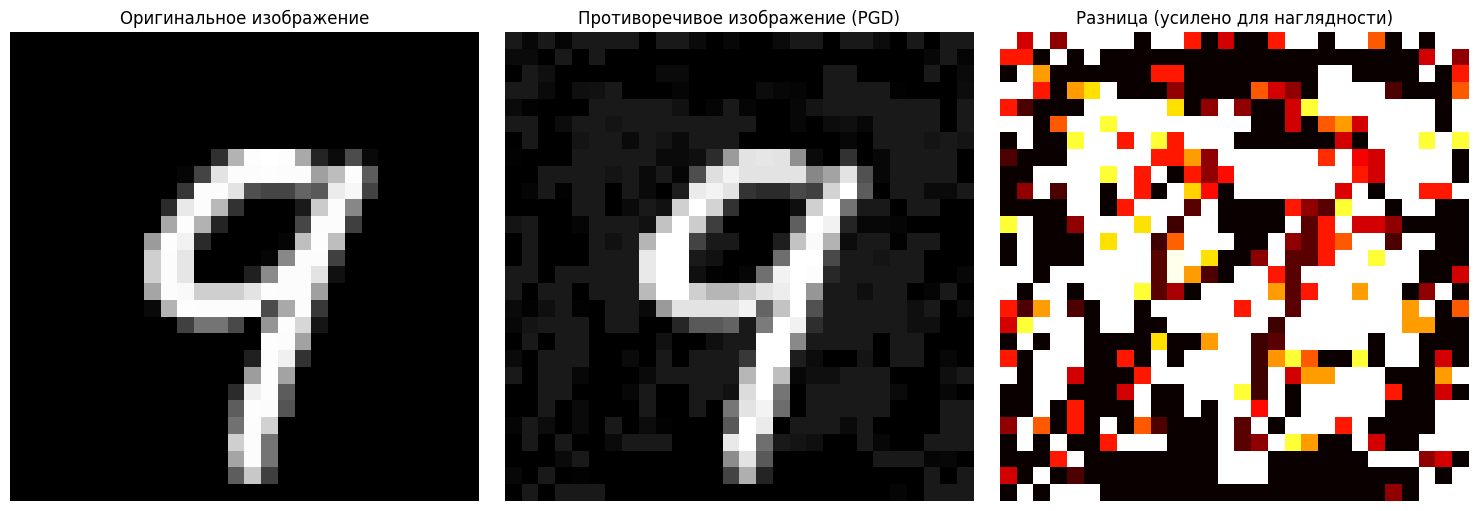

In [217]:
# Параметры PGD
epsilon = 0.3
alpha = 0.01
iterations = 10

# PGD атака
def pgd_attack(model, image, label, epsilon, alpha, iterations):
    adv_image = tf.convert_to_tensor(image)
    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            loss = tf.keras.losses.categorical_crossentropy(label, prediction)
        gradient = tape.gradient(loss, adv_image)
        adv_image = adv_image + alpha * tf.sign(gradient)
        adv_image = tf.clip_by_value(adv_image, image - epsilon, image + epsilon)
        adv_image = tf.clip_by_value(adv_image, 0, 1)
    return adv_image.numpy()

# Выбор примера
sample_idx = 12
original_image = x_test[sample_idx:sample_idx + 1]
original_label = y_test[sample_idx:sample_idx + 1]

# Создание атакованного изображения
adv_image = pgd_attack(model, original_image, original_label, epsilon, alpha, iterations)

# Получение предсказаний
original_pred_prob = model.predict(original_image, verbose=0)
adv_pred_prob = model.predict(adv_image, verbose=0)
original_pred = np.argmax(original_pred_prob)
adv_pred = np.argmax(adv_pred_prob)

# Точность в процентах
original_accuracy = original_pred_prob[0, np.argmax(original_label)] * 100
adv_accuracy = adv_pred_prob[0, np.argmax(original_label)] * 100

# Вывод точности
print(f"Предсказание оригинальное изображение : {original_pred}, Accuracy: {original_accuracy:.2f}%")
print(f"Предсказание противоречивое изображение: {adv_pred}, Accuracy: {adv_accuracy:.2f}%")

# Визуализация
difference = np.abs(adv_image - original_image)

plt.figure(figsize=(15, 5))

# Оригинальное изображение
plt.subplot(1, 3, 1)
plt.title("Оригинальное изображение")
plt.imshow(original_image[0, :, :, 0], cmap='gray')
plt.axis('off')

# Противоречивое изображение
plt.subplot(1, 3, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(adv_image[0, :, :, 0], cmap='gray')
plt.axis('off')

# Разница
plt.subplot(1, 3, 3)
plt.title("Разница (усилено для наглядности)")
plt.imshow(difference[0, :, :, 0] * 10, cmap='hot')  # Усиление контраста
plt.axis('off')

plt.tight_layout()
plt.show()

## Вывод

Модель правильно классифицировала оригинальное изображение как цифру 9 с высокой точностью 99.97%, что подтверждает её способность корректно обрабатывать исходные данные.

После внесения небольших возмущений PGD-атакой изображение было классифицировано как цифра 4, что является ошибкой. Точность на этом изображении снизилась до 0.30%, демонстрируя уязвимость модели к противоречивым примерам.

PGD-атака успешно ввела модель в заблуждение, хотя визуальные изменения в изображении были минимальны.